# Train

In [23]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

import src.face_recognition.ml_models as ml_models
import src.modules.data_loader as data_loader
import src.config as config

config.ANONY_IMAGES_PATH = '../data/dataset-lfw_reconstructed'
ML_OUTPUT = r"..\data\ml_models"
config.MODEL_SAVE_DIR = f'{ML_OUTPUT}/trained'
config.LOG_DIR = f'{ML_OUTPUT}/logs'
config.IMG_WIDTH, config.IMG_HEIGHT, config.CHANNELS = (100, 100, 1)



In [24]:
print("--- Démarrage du Script d'Entraînement ---")
start_time = time.time()

# --- 1. Chargement de la Configuration ---
print("Configuration chargée depuis config.py:")
print(f"  - Dossier Données: {config.ANONY_IMAGES_PATH}")
print(f"  - Dossier Sauvegarde Modèles: {config.MODEL_SAVE_DIR}")
print(f"  - Architecture Modèle: {config.MODEL_ARCHITECTURE}")
print(f"  - Nom Modèle: {config.MODEL_NAME}")
print(f"  - Dimensions Image: {config.IMG_HEIGHT}x{config.IMG_WIDTH}x{config.CHANNELS}")
print(f"  - Stratégie Split: {config.SPLIT_STRATEGY}")
print(f"  - Époques: {config.EPOCHS}, Batch Size: {config.BATCH_SIZE}")

os.makedirs(config.MODEL_SAVE_DIR, exist_ok=True)
if hasattr(config, 'LOG_DIR') and config.LOG_DIR:
    os.makedirs(config.LOG_DIR, exist_ok=True)
    print(f"  - Dossier Logs TensorBoard: {config.LOG_DIR}")


--- Démarrage du Script d'Entraînement ---
Configuration chargée depuis config.py:
  - Dossier Données: ../data/dataset-lfw_reconstructed
  - Dossier Sauvegarde Modèles: ..\data\ml_models/trained
  - Architecture Modèle: simple_cnn
  - Nom Modèle: simple_cnn_lfw_anony_v1
  - Dimensions Image: 100x100x1
  - Stratégie Split: stratified
  - Époques: 50, Batch Size: 32
  - Dossier Logs TensorBoard: ..\data\ml_models/logs


In [25]:
# --- 2. Chargement et Préparation des Données ---
print("\n--- Chargement des données ---")
X, y, label_encoder = data_loader.load_anonymized_images_flat(
    data_dir=config.ANONY_IMAGES_PATH,
    img_width=config.IMG_WIDTH,
    img_height=config.IMG_HEIGHT,
    color_mode=config.COLOR_MODE
)

if X is None or y is None or label_encoder is None:
    print("Erreur critique lors du chargement des données. Arrêt du script.")


num_classes = len(label_encoder.classes_)
input_shape = (config.IMG_HEIGHT, config.IMG_WIDTH, config.CHANNELS)
print(f"Nombre de classes détectées : {num_classes}")


--- Chargement des données ---
Chargement des images depuis : ../data/dataset-lfw_reconstructed
Format attendu : 100x100, mode: grayscale
Trouvé 1240 fichiers PNG.
Chargement terminé. 1240 images traitées, 0 fichiers ignorés.
Shape final des données (X): (1240, 100, 100, 1)
1240 labels originaux encodés en 62 classes numériques.
Nombre de classes détectées : 62


In [26]:
# --- 3. Division des Données ---
print("\n--- Division des données ---")
X_train, y_train = None, None
X_val, y_val = None, None
X_test, y_test = None, None

if config.SPLIT_STRATEGY == 'stratified':
    data_splits = data_loader.split_data_stratified(
        X, y,
        test_size=config.TEST_SPLIT_RATIO,
        validation_size=config.VALIDATION_SPLIT_RATIO,
        random_state=config.RANDOM_STATE
    )
    X_train = data_splits.get('X_train')
    y_train = data_splits.get('y_train')
    X_val = data_splits.get('X_val')
    y_val = data_splits.get('y_val')
    X_test = data_splits.get('X_test')
    y_test = data_splits.get('y_test')

    if X_val is None and config.VALIDATION_SPLIT_RATIO > 0 and X_train is not None and len(X_train) > 0:
         val_ratio_from_train = config.VALIDATION_SPLIT_RATIO / (1.0 - config.TEST_SPLIT_RATIO)
         if val_ratio_from_train < 1.0:
             print(f"Création du set de validation depuis l'entraînement (ratio: {val_ratio_from_train:.2f})")
             X_train, X_val, y_train, y_val = train_test_split(
                 X_train, y_train,
                 test_size=val_ratio_from_train,
                 random_state=config.RANDOM_STATE,
                 stratify=y_train
             )
         else:
             print("Attention: Ratios de split incohérents, pas de données d'entraînement restantes après validation.")

elif config.SPLIT_STRATEGY == 'fixed_per_subject':
    X_train_full, X_test, y_train_full, y_test = data_loader.split_data_fixed_per_subject(
        X, y,
        n_train_per_class=config.N_TRAIN_PER_SUBJECT,
        random_state=config.RANDOM_STATE
    )
    if config.VALIDATION_SPLIT_RATIO > 0 and X_train_full is not None and len(X_train_full) > 0:
        print(f"Création du set de validation depuis l'entraînement (ratio: {config.VALIDATION_SPLIT_RATIO})")
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=config.VALIDATION_SPLIT_RATIO,
            random_state=config.RANDOM_STATE,
            stratify=y_train_full
        )
    else:
        X_train, y_train = X_train_full, y_train_full
        X_val, y_val = None, None

else:
    print(f"Erreur: Stratégie de split '{config.SPLIT_STRATEGY}' non reconnue.")

if X_train is None or len(X_train) == 0:
    print("Erreur: Aucune donnée d'entraînement disponible après la division.")

if X_val is None or len(X_val) == 0:
    print("Attention: Aucune donnée de validation disponible. L'entraînement se fera sans suivi de validation.")
    validation_data = None # `fit` utilisera pas de validation
else:
    validation_data = (X_val, y_val)
    print(f"Taille finale - Entraînement: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test) if X_test is not None else 0}")


--- Division des données ---
Division des données : test_size=0.2, validation_size=0.15
Taille Test: 248 échantillons
Taille Entraînement: 806 échantillons
Taille Validation: 186 échantillons
Taille finale - Entraînement: 806, Validation: 186, Test: 248


In [27]:
# --- 4. Construction du Modèle ---
print("\n--- Construction du modèle ---")
model = None
if config.MODEL_ARCHITECTURE == 'simple_cnn':
    model = ml_models.build_simple_cnn(input_shape=input_shape, num_classes=num_classes)
elif config.MODEL_ARCHITECTURE.startswith('transfer_'):
    base_name = getattr(config, 'TRANSFER_BASE_MODEL_NAME', 'MobileNetV2')
    freeze = getattr(config, 'TRANSFER_FREEZE_BASE', True)
    print(f"Utilisation du modèle de base: {base_name}, Freeze: {freeze}")
    model = ml_models.build_transfer_model(input_shape=input_shape,
                                           num_classes=num_classes,
                                           base_model_name=base_name,
                                           freeze_base=freeze)
else:
    print(f"Erreur: Architecture de modèle non reconnue dans config: {config.MODEL_ARCHITECTURE}")

if model is None:
    print("Erreur critique lors de la construction du modèle. Arrêt.")

# --- 5. Compilation du Modèle ---
print("\n--- Compilation du modèle ---")
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print("Modèle compilé avec Adam optimizer.")
model.summary()


--- Construction du modèle ---
Construction du modèle CNN simple avec input_shape=(100, 100, 1) et num_classes=62
Modèle CNN simple construit.

--- Compilation du modèle ---
Modèle compilé avec Adam optimizer.


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 100, 100, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 50, 50, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense1 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,194,398 (19.82 MB)

 Trainable params: 5,193,758 (19.81 MB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
# --- 6. Configuration des Callbacks ---
print("\n--- Configuration des Callbacks ---")
callbacks = []

model_filename = f"{config.MODEL_NAME}.h5"
model_filepath = os.path.join(config.MODEL_SAVE_DIR, model_filename)
print(f"  - ModelCheckpoint: Sauvegarde du meilleur modèle dans {model_filepath}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
callbacks.append(checkpoint_callback)

if hasattr(config, 'EARLY_STOPPING_PATIENCE') and config.EARLY_STOPPING_PATIENCE > 0:
    print(f"  - EarlyStopping: Activé avec patience={config.EARLY_STOPPING_PATIENCE}")
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=config.EARLY_STOPPING_PATIENCE,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping_callback)
else:
    print("  - EarlyStopping: Désactivé.")


if hasattr(config, 'LOG_DIR') and config.LOG_DIR:
    tensorboard_log_dir = os.path.join(config.LOG_DIR, config.MODEL_NAME + "_" + time.strftime("%Y%m%d-%H%M%S"))
    print(f"  - TensorBoard: Logs dans {tensorboard_log_dir}")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir,
        histogram_freq=1
    )
    callbacks.append(tensorboard_callback)
else:
    print("  - TensorBoard: Désactivé.")

csv_log_path = os.path.join(config.MODEL_SAVE_DIR, f"{config.MODEL_NAME}_training_log.csv")
print(f"  - CSVLogger: Logs dans {csv_log_path}")
csv_logger_callback = tf.keras.callbacks.CSVLogger(csv_log_path, append=False)
callbacks.append(csv_logger_callback)


--- Configuration des Callbacks ---
  - ModelCheckpoint: Sauvegarde du meilleur modèle dans ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
  - EarlyStopping: Activé avec patience=10
  - TensorBoard: Logs dans ..\data\ml_models/logs\simple_cnn_lfw_anony_v1_20250427-161202
  - CSVLogger: Logs dans ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_training_log.csv


In [11]:
# --- 7. Entraînement du Modèle ---
print("\n--- Démarrage de l'entraînement ---")
history = None
try:
    history = model.fit(
        X_train, y_train,
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1
    )
    print("--- Entraînement terminé ---")

except Exception as e:
    print(f"\nErreur pendant l'entraînement : {e}")
    encoder_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{config.MODEL_NAME}_label_encoder.joblib")
    print("\nSauvegarde de l'encodeur de labels (même si l'entraînement a échoué)...")
    data_loader.save_label_encoder(label_encoder, encoder_save_path)


--- Démarrage de l'entraînement ---
Epoch 1/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0647 - loss: 4.4573
Epoch 1: val_accuracy improved from -inf to 0.01613, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.0672 - loss: 4.4231 - val_accuracy: 0.0161 - val_loss: 4.5659
Epoch 2/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3404 - loss: 2.8352
Epoch 2: val_accuracy did not improve from 0.01613
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3449 - loss: 2.8189 - val_accuracy: 0.0161 - val_loss: 5.7831
Epoch 3/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6640 - loss: 1.8014
Epoch 3: val_accuracy did not improve from 0.01613
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6676 - loss: 1.7889 - val_accuracy: 0.0161 - val_loss: 6.4339
Epoch 4/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8597 - loss: 1.1047
Epoch 4: val_accuracy did not improve from 0.01613
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8612 - loss: 1.0984 - val_accuracy: 0.0161 - val_loss: 5.5986
Epoch 5/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9658 - loss: 0.6356
Epoch 5: val_accuracy did not improve fr

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9824 - loss: 0.4082 - val_accuracy: 0.0269 - val_loss: 5.5324
Epoch 7/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9909 - loss: 0.3220
Epoch 7: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9910 - loss: 0.3197 - val_accuracy: 0.0161 - val_loss: 5.3222
Epoch 8/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9999 - loss: 0.2280
Epoch 8: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9999 - loss: 0.2296 - val_accuracy: 0.0161 - val_loss: 22.2569
Epoch 9/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9871 - loss: 0.3020
Epoch 9: val_accuracy did not improve from 0.02688
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9875 - loss: 0.2991 - val_accuracy: 0.0161 - val_loss: 16.8663
Epoch 10/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.1895 
Epoch 10: val_accuracy did not improv

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 0.0860 - val_accuracy: 0.0968 - val_loss: 4.3256
Epoch 13/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0834
Epoch 13: val_accuracy improved from 0.09677 to 0.18280, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 0.0833 - val_accuracy: 0.1828 - val_loss: 3.5303
Epoch 14/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0779
Epoch 14: val_accuracy improved from 0.18280 to 0.27419, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0777 - val_accuracy: 0.2742 - val_loss: 3.0939
Epoch 15/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9996 - loss: 0.0675
Epoch 15: val_accuracy improved from 0.27419 to 0.46774, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9995 - loss: 0.0674 - val_accuracy: 0.4677 - val_loss: 2.4487
Epoch 16/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0589
Epoch 16: val_accuracy improved from 0.46774 to 0.69892, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 0.0589 - val_accuracy: 0.6989 - val_loss: 1.7207
Epoch 17/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0503
Epoch 17: val_accuracy improved from 0.69892 to 0.76344, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 1.0000 - loss: 0.0505 - val_accuracy: 0.7634 - val_loss: 1.3576
Epoch 18/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0495
Epoch 18: val_accuracy improved from 0.76344 to 0.93011, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 1.0000 - loss: 0.0495 - val_accuracy: 0.9301 - val_loss: 0.8404
Epoch 19/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0451
Epoch 19: val_accuracy improved from 0.93011 to 0.96237, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 0.0450 - val_accuracy: 0.9624 - val_loss: 0.5484
Epoch 20/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0382
Epoch 20: val_accuracy improved from 0.96237 to 0.97849, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 0.0385 - val_accuracy: 0.9785 - val_loss: 0.4253
Epoch 21/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0423
Epoch 21: val_accuracy improved from 0.97849 to 0.98387, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 0.0421 - val_accuracy: 0.9839 - val_loss: 0.2974
Epoch 22/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0384
Epoch 22: val_accuracy improved from 0.98387 to 0.98925, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0382 - val_accuracy: 0.9892 - val_loss: 0.2172
Epoch 23/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0330
Epoch 23: val_accuracy did not improve from 0.98925
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 0.9892 - val_loss: 0.1805
Epoch 24/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0307
Epoch 24: val_accuracy did not improve from 0.98925
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.9892 - val_loss: 0.1527
Epoch 25/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0264
Epoch 25: val_accuracy improved from 0.98925 to 0.99462, saving model to ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 0.9946 - val_loss: 0.1176
Epoch 26/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0260
Epoch 26: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 0.0261 - val_accuracy: 0.9946 - val_loss: 0.1099
Epoch 27/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0252
Epoch 27: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.9892 - val_loss: 0.1021
Epoch 28/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0199
Epoch 28: val_accuracy did not improve from 0.99462
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.9946 - val_loss: 0.0940
Epoch 29/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0206
Epoch 29: val_accuracy did not im

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 0.0684
Epoch 33/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0193
Epoch 33: val_accuracy did not improve from 1.00000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0727
Epoch 34/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0163
Epoch 34: val_accuracy did not improve from 1.00000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0752
Epoch 35/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0176
Epoch 35: val_accuracy did not improve from 1.00000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 0.9946 - val_loss: 0.0901
Epoch 36/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0208
Epoch 36: val_accuracy did not 


--- Sauvegarde de l'encodeur de labels ---
LabelEncoder sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib

--- Affichage des courbes d'apprentissage ---
Courbes sauvegardées dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_training_curves.pdf

--- Script d'Entraînement Terminé en 119.25 secondes ---
Le meilleur modèle devrait être sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
L'encodeur de labels est sauvegardé dans : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib


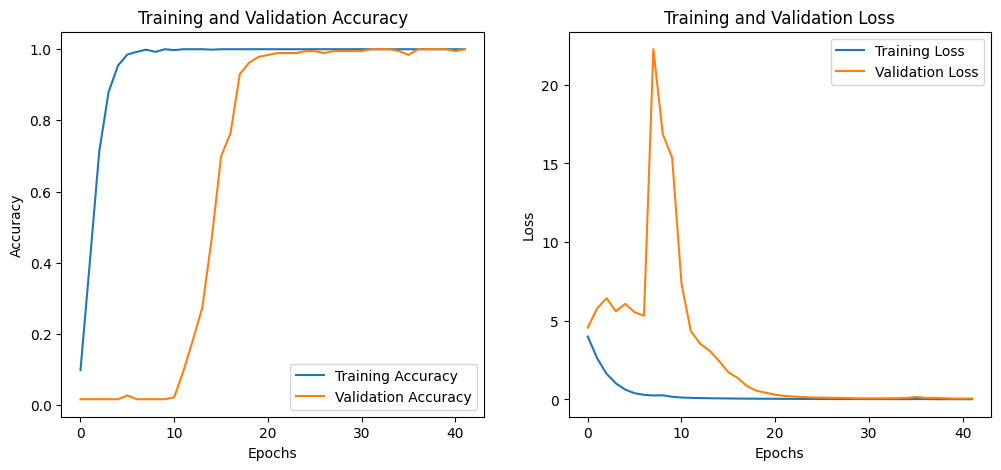

In [12]:
# --- 8. Post-Entraînement ---
encoder_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{config.MODEL_NAME}_label_encoder.joblib")
print("\n--- Sauvegarde de l'encodeur de labels ---")
data_loader.save_label_encoder(label_encoder, encoder_save_path)

if history is not None:
    print("\n--- Affichage des courbes d'apprentissage ---")
    try:
        acc = history.history['accuracy']
        loss = history.history['loss']
        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        if validation_data: # Seulement si validation existe
             val_acc = history.history['val_accuracy']
             plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        if validation_data: # Seulement si validation existe
            val_loss = history.history['val_loss']
            plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plot_save_path = os.path.join(config.MODEL_SAVE_DIR, f"{config.MODEL_NAME}_training_curves.pdf")
        plt.savefig(plot_save_path, format='pdf', bbox_inches='tight')
        print(f"Courbes sauvegardées dans : {plot_save_path}")

    except Exception as plot_e:
        print(f"Erreur lors de la génération/sauvegarde des courbes: {plot_e}")


end_time = time.time()
duration = end_time - start_time
print(f"\n--- Script d'Entraînement Terminé en {duration:.2f} secondes ---")
print(f"Le meilleur modèle devrait être sauvegardé dans : {model_filepath}")
print(f"L'encodeur de labels est sauvegardé dans : {encoder_save_path}")



# Predict

In [18]:
import os
import numpy as np
import time
from typing import Optional
from PIL import Image

user = 5
image_path = f"../data/dataset-lfw_reconstructed/reconstructed_{user}_2.png"

In [19]:
print("--- Démarrage du Script de Prédiction ---")
start_time = time.time()

# --- 1. Charger Configuration et Chemins ---
print("Chargement de la configuration...")
model_filename = f"{config.MODEL_NAME}.h5" # ou .keras
model_filepath = os.path.join(config.MODEL_SAVE_DIR, model_filename)
encoder_filename = f"{config.MODEL_NAME}_label_encoder.joblib"
encoder_filepath = os.path.join(config.MODEL_SAVE_DIR, encoder_filename)

print(f"  - Modèle utilisé: {model_filepath}")
print(f"  - Encodeur utilisé: {encoder_filepath}")
print(f"  - Image à prédire: {image_path}")

--- Démarrage du Script de Prédiction ---
Chargement de la configuration...
  - Modèle utilisé: ..\data\ml_models/trained\simple_cnn_lfw_anony_v1.h5
  - Encodeur utilisé: ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib
  - Image à prédire: ../data/dataset-lfw_reconstructed/reconstructed_6_2.png


In [20]:
# --- 2. Charger Modèle et Encodeur ---
print("\n--- Chargement du modèle et de l'encodeur ---")
if not os.path.exists(model_filepath):
    print(f"Erreur: Fichier modèle non trouvé: {model_filepath}")
try:
    model = tf.keras.models.load_model(model_filepath)
    print("Modèle chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle Keras: {e}")

# Charger l'encodeur de labels
label_encoder = data_loader.load_label_encoder(encoder_filepath)
if label_encoder is None:
    print("Erreur critique : Impossible de charger l'encodeur de labels.")


--- Chargement du modèle et de l'encodeur ---
Modèle chargé avec succès.
LabelEncoder chargé depuis : ..\data\ml_models/trained\simple_cnn_lfw_anony_v1_label_encoder.joblib


In [21]:
# --- 3. Prétraiter l'Image d'Entrée ---

def preprocess_single_image(
    image_path: str,
    img_width: int,
    img_height: int,
    color_mode: str
) -> Optional[np.ndarray]:
    """
    Charge, redimensionne, normalise et formate une image unique pour la prédiction.
    """
    try:
        img = Image.open(image_path)

        pil_mode = 'L' if color_mode == 'grayscale' else 'RGB'
        img_converted = img.convert(pil_mode)

        img_resized = img_converted.resize((img_width, img_height))

        img_array = np.array(img_resized)

        img_normalized = img_array.astype('float32') / 255.0

        if color_mode == 'grayscale':
            img_final = np.expand_dims(img_normalized, axis=-1)
        else:
            img_final = img_normalized

        img_batch = np.expand_dims(img_final, axis=0)

        print(f"Image prétraitée, shape final: {img_batch.shape}")
        return img_batch

    except FileNotFoundError:
        print(f"Erreur: Fichier image introuvable : {image_path}")
        return None
    except Exception as e:
        print(f"Erreur lors du prétraitement de l'image {image_path}: {e}")
        return None

print("\n--- Prétraitement de l'image d'entrée ---")
preprocessed_image = preprocess_single_image(
    image_path=image_path,
    img_width=config.IMG_WIDTH,
    img_height=config.IMG_HEIGHT,
    color_mode=config.COLOR_MODE
)

if preprocessed_image is None:
    print("Échec du prétraitement de l'image.")


--- Prétraitement de l'image d'entrée ---
Image prétraitée, shape final: (1, 64, 64, 1)


In [22]:
# --- 4. Faire la Prédiction ---
print("\n--- Prédiction ---")
try:
    prediction_probabilities = model.predict(preprocessed_image)

    predicted_index = np.argmax(prediction_probabilities[0])
    prediction_confidence = prediction_probabilities[0][predicted_index]

    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    print("\n--- Résultat de la Prédiction ---")
    print(f"  - Image : {os.path.basename(image_path)}")
    print(f"  - Identité Prédite (Subject ID) : {predicted_label}")
    print(f"  - Confiance : {prediction_confidence:.4f} ({prediction_confidence*100:.2f}%)")

except Exception as e:
    print(f"Erreur lors de la prédiction: {e}")

end_time = time.time()
duration = end_time - start_time
print(f"\n--- Script de Prédiction Terminé en {duration:.2f} secondes ---")

print(predicted_label)


--- Prédiction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

--- Résultat de la Prédiction ---
  - Image : reconstructed_6_2.png
  - Identité Prédite (Subject ID) : 6
  - Confiance : 0.9966 (99.66%)

--- Script de Prédiction Terminé en 7.21 secondes ---
6


D:\myDocs\Apprentissage\Isep\Year_3\Brno-Privacy_Preserving_Face_Recognition_Project\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)
